In [3]:
# === Automatizador: corre todo el pipeline sobre múltiples áreas ===
import pathlib
import re, ast
import warnings
import traceback
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

from typing import List, Dict
from shapely.geometry import Polygon

from utils.ncba import detect_ncba
from utils.preprocessing import filtering_timeseries, save_features
from utils.plotting import (select_indices_separated, plot_s2_timeline, plot_entire_timeline, 
                            unified_closeup_and_ts)
from utils.cloud_detection import (get_s1_col, get_s2cloudless_collection, get_matching_s1_s2, 
                                   get_images)
from utils.change_indicators import (kliep_score, compute_change_metrics, get_predictions,
                                     generate_residuals, build_results_dataframe_from_scalar, 
                                     scan_temporal_consistency, summarize_top_changes) 

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **k):
        return x

def parse_areas_file(path: str) -> List[Dict]:    
    txt = pathlib.Path(path).read_text(encoding='utf-8')
    blocks = re.split(r'(?m)^##\s*([A-Za-z]\d+)\s*$', txt)
    areas = []
    for i in range(1, len(blocks), 2):
        code = blocks[i].strip()
        body = blocks[i+1]

        m = re.search(r'LAT\s*,\s*LON\s*=\s*([\-0-9\.]+)\s*,\s*([\-0-9\.]+)', body)
        ms = re.search(r'START_DATE\s*=\s*["\']([^"\']+)["\']', body)
        me = re.search(r'END_DATE\s*=\s*["\']([^"\']+)["\']', body)
        if not (m and ms and me):
            continue

        p = re.search(r'POLYGON\s*=\s*\[', body)
        if not p:
            continue
        start = p.end() - 1
        depth = 0
        end = None
        for j in range(start, len(body)):
            ch = body[j]
            if ch == '[':
                depth += 1
            elif ch == ']':
                depth -= 1
                if depth == 0:
                    end = j
                    break
        if end is None:
            raise ValueError(f"No se pudo cerrar POLYGON en bloque {code}")
        polygon_str = body[start:end+1]
        polygon_str = polygon_str.replace('\t', '    ')
        polygon = ast.literal_eval(polygon_str)

        lat = float(m.group(1)); lon = float(m.group(2))
        areas.append({
            'code': code,
            'lat': lat,
            'lon': lon,
            'start_date': ms.group(1),
            'end_date': me.group(1),
            'polygon': polygon
        })
    return areas


def run_batch(areas_file: str, codes_to_run=None, max_areas=None):
    codes_to_run = set(map(str.upper, codes_to_run or []))
    areas = parse_areas_file(areas_file)
    if codes_to_run:
        areas = [a for a in areas if a['code'].upper() in codes_to_run]
    if max_areas is not None:
        areas = areas[:int(max_areas)]
    print(f'Ejecutando {len(areas)} áreas:', [a['code'] for a in areas])
    failures = []
    try:
        _areas_iter = tqdm(areas, desc='Áreas', unit='área')
    except Exception:
        _areas_iter = areas
    for a in _areas_iter:
        if hasattr(_areas_iter, 'set_postfix_str'):
            _areas_iter.set_postfix_str(a['code'])
        try:
            ## Initial setup for each area
            print(f"\n=== Área {a['code']} ({a['start_date']} → {a['end_date']}) ===")
            code = a['code'].lower()
            pathlib.Path(f"../outputs/{code}").mkdir(parents=True, exist_ok=True)
            LAT, LON = a['lat'], a['lon']
            START_DATE, END_DATE = a['start_date'], a['end_date']
            POLYGON = a['polygon']

            polygon_coords = [tuple(coord) for coord in POLYGON[0]]
            shape = Polygon(polygon_coords)

            ## Default download parameters 
            CLOUD_FRACTION = 0.5 
            PATCH_SIZE = 64 
            S2_BANDS = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "AOT"] 
            S1_BANDS = ["VV", "VH"] 

            # Apply the cloudless filter to the collection 
            image_collection_s2 = get_s2cloudless_collection(LAT, LON, START_DATE, END_DATE, CLOUD_FRACTION, 
                                                             PATCH_SIZE) 
            image_collection_s1 = get_s1_col(LAT, LON, START_DATE, END_DATE, PATCH_SIZE, orbit_pass='DESCENDING') 
            matched_s1_col, matched_s2_col, _ = get_matching_s1_s2(image_collection_s1, image_collection_s2) 

            # Get the images 
            s2_images, s2_profile = get_images(LAT, LON, matched_s2_col, S2_BANDS, PATCH_SIZE, include_clouds=True) 
            s1_images, _ = get_images(LAT, LON, matched_s1_col, S1_BANDS, PATCH_SIZE) 
            print(f"Number of S2 images: {len(s2_images)}, Number of S1 images: {len(s1_images)}")
            
            ## Plot the entire timeline                    
            plot_entire_timeline(s2_images, code, type_image="sentinel2", show=False)

            # Randomly select 4 images well separated in time for visualization
            selected_idx = select_indices_separated(len(s2_images), k=4, min_sep=4)
            plot_s2_timeline(s2_images, code, selected_idx=selected_idx, show=False, type_image="sentinel2")
            
            ## Filtering the time series
            s1_f, s2_f, _ = filtering_timeseries(s1_images, s2_images, normalize=False, local_blocks=2, 
                                                 clear_fraction_thresh=0.70, kld_thresh=0.20)

            plot_entire_timeline(s2_f, code, type_image="sentinel2_filtered", show=False)
            plot_s2_timeline(s2_f, code, selected_idx=selected_idx, show=False, type_image="sentinel2_filtered")                 
        
            if code.startswith('e'):
                out_arrays = get_predictions(s1_f, s2_f, method="multi_task")
            elif code.startswith('v'):
                out_arrays = get_predictions(s1_f, s2_f, method="one_task")

            # Semantic segmentation
            plot_entire_timeline(out_arrays, code, type_image="predicted", show=False)
            plot_s2_timeline(out_arrays, code, selected_idx=selected_idx, show=False, type_image="predicted")          

            # Get the change indicators 
            if code.startswith("e"):
                features = save_features(s2_f, s1_f, s2_profile, shape, model="multi_task")
            elif code.startswith("v"):
                features = save_features(s2_f, s1_f, s2_profile, shape, model="one_task")

            kliep_scores, kliep_t1s, kliep_t2s = kliep_score(np.array(features["features"]), cloud_band_index=3, 
                                                             cloud_thresh=30) 
            # Generate the residuals 
            residuals_df = generate_residuals(features, kliep_t1s, s2_f, period=3) 

            # Get the metrics 
            results = [] 
            for i, (t1, t2) in enumerate(zip(kliep_t1s, kliep_t2s)): 
                # toma 3 primeros canales para métricas (ajusta si necesitas otros) 
                feat_t1 = features["features"][t1][:3] 
                feat_t2 = features["features"][t2][:3] 
                metrics_dict = compute_change_metrics(feat_t1, feat_t2, class_names=["building", "road", "background"], 
                                                    bg_full_tol=0.05, frac_mode="soft", dominant_mode="auto", 
                                                    min_change_for_to=0.05)
                
                results.append({ "t1": int(t1), 
                                "t2": int(t2), 
                                "score": float(kliep_scores[i]), 
                                "date_change": pd.to_datetime(s2_f[int(t2)]["date"]).strftime("%Y-%m-%d"), 
                                "cva_mag_mean": float(metrics_dict["mean_magnitude"]), 
                                "dominant_label": metrics_dict["dominant_label"], 
                                "rate_bu_change": float(metrics_dict["change_rates"]["building"]), 
                                "rate_ro_change": float(metrics_dict["change_rates"]["road"]), 
                                "rate_bk_change": float(metrics_dict["change_rates"]["background"])}) 
    
            # Create the dataframe 
            df_metrics = build_results_dataframe_from_scalar(results, area_id="A01", series_id="S01", residuals_df=residuals_df) 

            # Scan temporal consistency
            df_windows = scan_temporal_consistency(
                        df_metrics,
                        window_pairs=7, step_pairs=1,
                        residuals_df=residuals_df,
                        repeats_required_pre=0, repeats_required_post=3,
                        rate_change_threshold=0.05,
                        window_mode="row",       
                        anchor="center"         
                    )

            # Summarize_top_changes
            top_df = summarize_top_changes(df_metrics, df_windows, top_n=3)
            top_df.to_csv(f"../outputs/{code}/top_changes_{code}.csv", index=False) 

            # Print top changes
            print(top_df)

            # Prompt the user for `idx` or use the default value
            user_input = input(f"Enter idx for area {code} (press Enter to use default): ")
            if user_input.strip():  # If the user provides a value
                idx = int(user_input)
            else:  # Use the default value from top_df
                idx = top_df["center_t1"].values[0]

            print(f"Using idx: {idx}")

            if code.startswith("e"):
                pred = np.array([np.nanmean(features['features'][i][0]) for i in range(len(features['features']))])
            elif code.startswith("v"):
                pred = np.array([np.nanmean(features['features'][i][1]) for i in range(len(features['features']))])

            results, *_ = detect_ncba(pred, alpha=1.0)

            # Collect all results in a list
            results_list = []

            for i, r in enumerate(results):
                date_change = pd.to_datetime(s2_f[int(r.change_t)]["date"]).strftime("%Y-%m-%d")
                
                # Append each result to the list
                results_list.append({
                    "change_t": int(r.change_t),
                    "t1": int(r.q1),
                    "t2": int(r.q2),
                    "magnitude": float(r.change_mag),
                    "date_change": date_change
                })

            # Create a DataFrame from the collected results
            df_ncba = pd.DataFrame(results_list)

            # Save the DataFrame to a CSV file
            df_ncba.to_csv(f"../outputs/{code}/ncba_{code}.csv", index=False)


            ## Closeup plots and graph
            if code.startswith('e'):
                unified_closeup_and_ts(out_arrays=out_arrays, s2_profile=s2_profile, shape=shape, idx=idx, df_metrics=df_metrics, 
                                    factor=1.5, circle_size=150, top_df=top_df, type="building",
                                    plot_polygon_in_closeups=False,
                                    panel_t1s=kliep_t1s, figsize=(12,6), overview_frac=0.30, top_panel_frac=0.5)
            elif code.startswith('v'):
                unified_closeup_and_ts(out_arrays=out_arrays, s2_profile=s2_profile, shape=shape, idx=idx, df_metrics=df_metrics, 
                                    factor=1.5, circle_size=150, top_df=top_df, type="road",
                                    plot_polygon_in_closeups=True,
                                    panel_t1s=kliep_t1s, figsize=(12,6), overview_frac=0.30, top_panel_frac=0.5)
            
        except Exception as e:
            print('[ERROR]', a['code'], e)
            traceback.print_exc()
            failures.append((a['code'], str(e)))

    if failures:
        print('\nFallos:')
        for code, err in failures:
            print(' -', code, err)

    else:
        print('\nTodas las áreas ejecutadas correctamente.')

Ejecutando 1 áreas: ['E07']


Áreas:   0%|          | 0/1 [00:00<?, ?área/s]


=== Área E07 (2021-07-01 → 2022-07-01) ===
Original collection size: 73
Collection with cloud score size: 73
Filtered collection size: 53
Original collection size: 43
Filtered collection size: 43
Found 53 valid image pairs.
Matching dates: ['S1:2021-07-06_S2:2021-07-02', 'S1:2021-07-06_S2:2021-07-07', 'S1:2021-07-12_S2:2021-07-12', 'S1:2021-07-18_S2:2021-07-17', 'S1:2021-07-24_S2:2021-07-22', 'S1:2021-07-30_S2:2021-07-27', 'S1:2021-07-30_S2:2021-08-01', 'S1:2021-08-05_S2:2021-08-06', 'S1:2021-08-17_S2:2021-08-11', 'S1:2021-08-17_S2:2021-08-16', 'S1:2021-08-23_S2:2021-08-21', 'S1:2021-08-29_S2:2021-08-26', 'S1:2021-08-29_S2:2021-08-31', 'S1:2021-09-04_S2:2021-09-05', 'S1:2021-09-16_S2:2021-09-15', 'S1:2021-09-22_S2:2021-09-20', 'S1:2021-09-28_S2:2021-09-25', 'S1:2021-09-28_S2:2021-09-30', 'S1:2021-10-10_S2:2021-10-10', 'S1:2021-10-16_S2:2021-10-15', 'S1:2021-10-28_S2:2021-10-25', 'S1:2021-11-03_S2:2021-11-04', 'S1:2021-11-09_S2:2021-11-09', 'S1:2021-11-15_S2:2021-11-14', 'S1:2021-11-21

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.121032715..1.3696289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.025125..1.422].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10784912..1.2736816].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04725..1.284].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08665466..1.331543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14962499999999998..1.419].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15197754..1.342

Using idx: 27


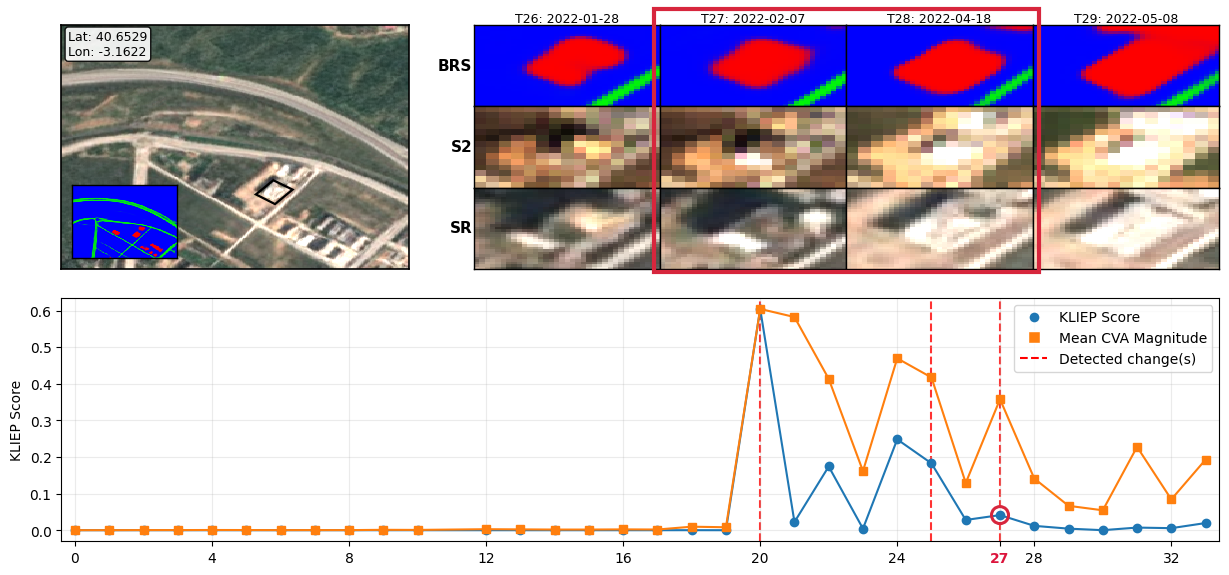


Todas las áreas ejecutadas correctamente.


In [13]:
run_batch(areas_file="../data/E00_areas.txt", codes_to_run=["EO6", "E07"])